In [1]:
import torch_geometric as tg
import torch
import torchvision as tv

import numpy as np

from architectures.vanilla_message_pasing import MPNN

import pytorch_lightning as pl
import torchmetrics

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
transforms = tg.transforms.RadiusGraph(8)

train_data = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=True)
test_data = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=False)

train_set_regular = tv.datasets.MNIST(root='./datasets',
                                      train=True,
                                      transform=tv.transforms.Compose([tv.transforms.ToTensor()]), download=False
                                      )

val_set_regular = tv.datasets.MNIST(root='./datasets',
                                    train=False,
                                    transform=tv.transforms.Compose([tv.transforms.ToTensor()]),
                                    download=False
                                    )


In [3]:
class MNISTClassifier(pl.LightningModule):
    def __init__(self, model, lr, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.lr = lr

        self.train_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.valid_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x, edge_index):
        return self.model(x=x, edge_index=edge_index, batch=None)

    def training_step(self, graph):
        pred = self(graph).squeeze()
        loss = torch.nn.functional.cross_entropy(pred, graph.y)
        self.train_metric(pred, graph.y)
        return loss

    def on_train_epoch_end(self):
        self.log("train acc", self.train_metric, prog_bar=True)

    def validation_step(self, graph, batch_idx):
        pred = self(graph).squeeze()
        self.valid_metric(pred, graph.y)

    def on_validation_epoch_end(self):
        self.log("valid acc", self.valid_metric, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [4]:
# Load up the pretrained model
node_features = 1
hidden_features = 64
out_features = 10
num_layers = 2

vanilla_mpnn = MPNN(node_features=node_features,
                    edge_features=0,
                    hidden_features=hidden_features,
                    out_features=out_features,
                    num_layers=num_layers,
                           )

# Load pretrained model
vanilla_mpnn = MNISTClassifier.load_from_checkpoint("./trained_models/tutorial/vanilla_mpnn.ckpt",
                                     model=vanilla_mpnn,
                                     lr=1e-3,
                                     map_location=torch.device("cpu"))

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\niksm\Documents\CodeForUni\geometron\trained_models\tutorial\vanilla_mpnn.ckpt`


### View images

In [5]:
def visualize_sample(idx, data, regular_data):


    sample_graph = data[idx].clone()
    sample_graph.pos -= sample_graph.pos.min()
    sample_graph.pos = sample_graph.pos/sample_graph.pos.max() * 2 - 1


    sample_mnist = regular_data[idx][0].squeeze(0)

    pos_dict = {}
    print(f"Digit: {sample_graph.y.item()}")
    for i, p in enumerate(sample_graph.pos):
        pos_dict[i] = p.numpy() * np.array([1, -1])


    g = tg.utils.to_networkx(sample_graph, to_undirected=True)

    f, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(sample_mnist.numpy(), extent=[-1,1,-1,1], cmap='Purples')
    nx.draw_networkx_nodes(g,
                           node_size=500,
                           node_color=sample_graph.x.cpu().numpy(),
                           node_shape=r'$\circ$',
                           pos=pos_dict,
                           cmap='Purples',
                            )

    nx.draw_networkx_edges(g, edge_color='r', alpha=0.5, pos=pos_dict)


Digit: 5


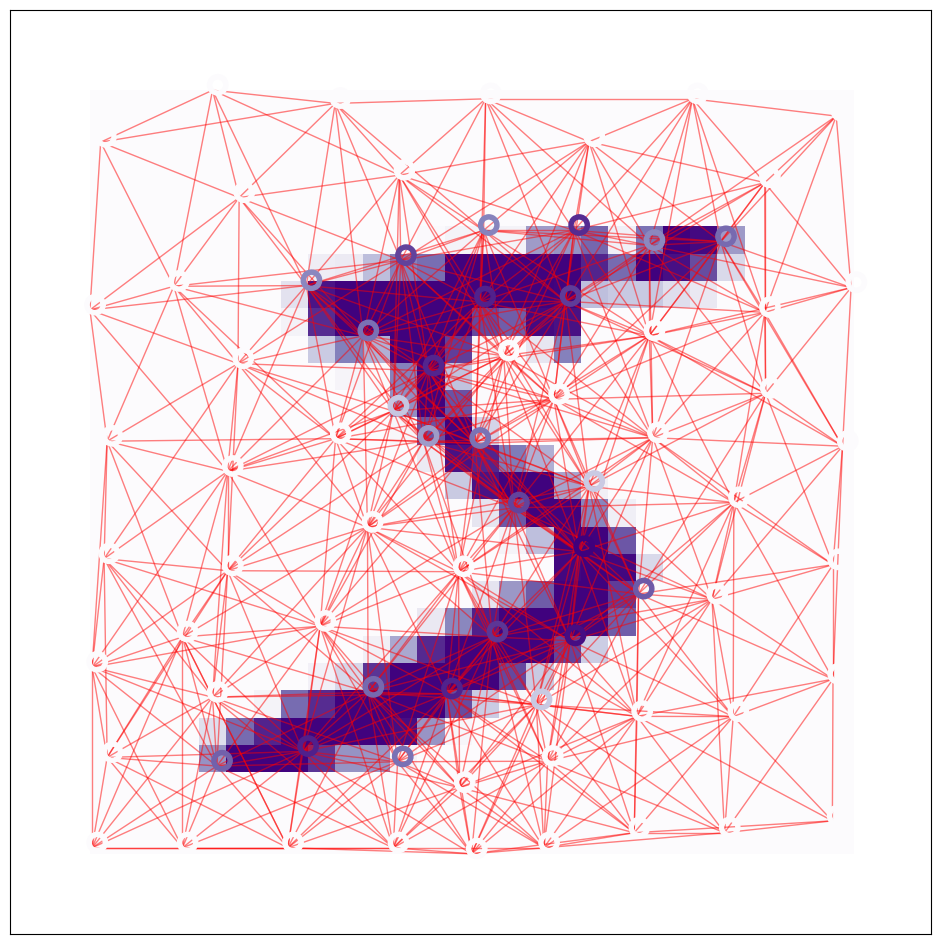

In [6]:
visualize_sample(0, train_data, train_set_regular)

### Setup Explainer
- We will start with integrated gradients and see if we can extend to gradientSHAP (not currently implemented in torch_geometric)
- I do think this should be possible, since we can just get the input tensors out, which is what gradientSHAP requires


In [45]:
# Can swap this out with a few different methods
captum_component = tg.explain.algorithm.CaptumExplainer(attribution_method='IntegratedGradients')

### Need to configure this for different models depending on how they use edge attributes/node_attributes

# Specify model properties
model_config = dict(mode='multiclass_classification', # could also be 'regression'
                    task_level='graph', # could also be 'node' or 'edge'
                    return_type='log_probs' # could also be probs or 'raw'
                    )

# The 'masks' refer to attributions for either all the nodes x node_features or edges x edge_features
# That is, a node mask is a mapping v_i -> attributions_i

explainer = tg.explain.Explainer(
    model=vanilla_mpnn, # This has to have a tensor output
    algorithm=captum_component,
    explanation_type='model', # Only other option is 'phenomenon'??
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config
)

In [46]:
to_attribute = test_data[0]


explanation = explainer(
    to_attribute.x,
    to_attribute.edge_index
)

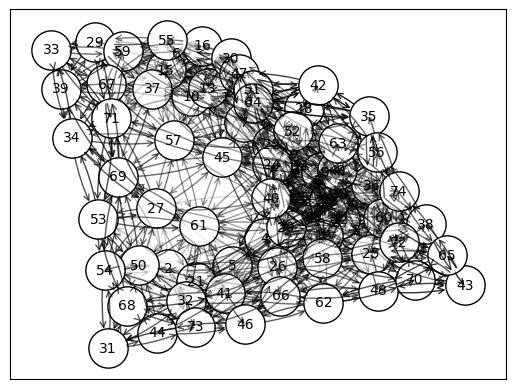

In [47]:
# Can visualise stuff but it isn't very helpful!
explanation.visualize_graph()

In [55]:
# Instead let's pull out the attributions directly
attributes = {i: explanation.node_mask[i].item()
              for i in range(explanation.node_mask.shape[0])
              }

attributes_list = np.array(explanation.node_mask)

### Let's try and visualise the explanations

Here we will rebuild the above visualisation function to allow us more control over the modelling

Digit: 5


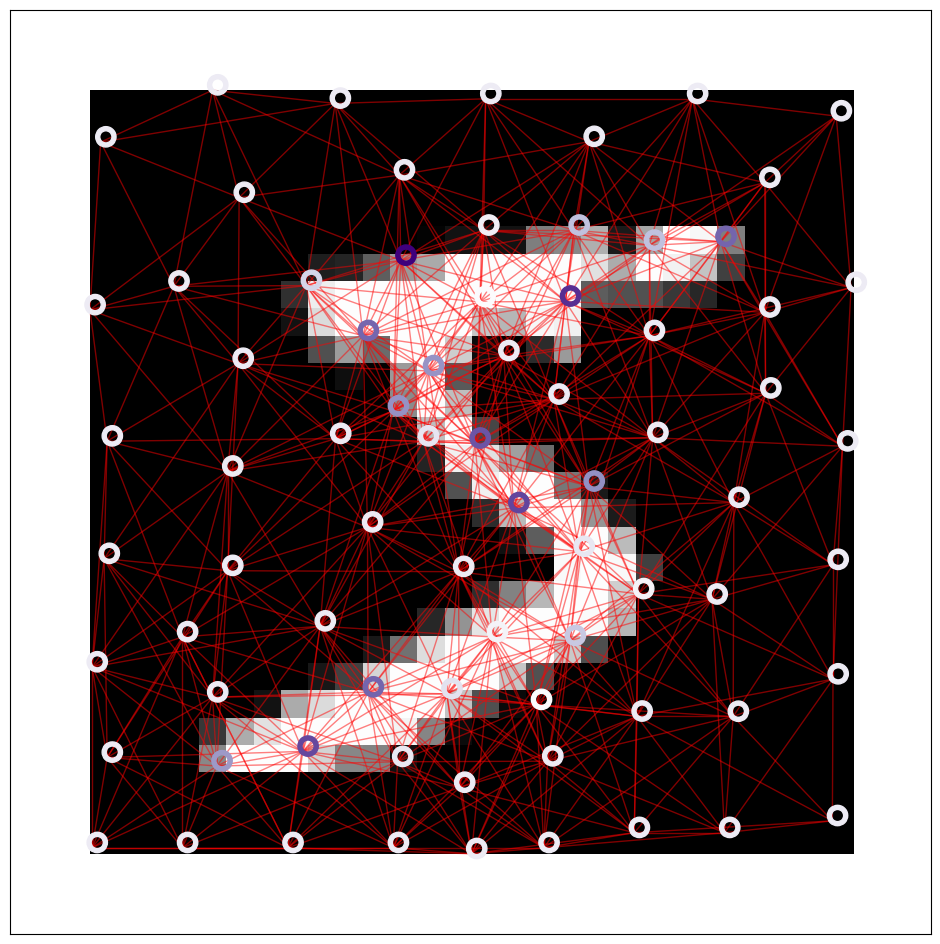

In [60]:
# Make these arguments later on
idx = 0
data = train_data
regular_data = train_set_regular
draw_edges = True
# attributes = attributes # This is also an argument


### Function Start

sample_graph = data[idx].clone()
sample_graph.pos -= sample_graph.pos.min()
sample_graph.pos = sample_graph.pos/sample_graph.pos.max() * 2 - 1

sample_mnist = regular_data[idx][0].squeeze(0)

pos_dict = {}
print(f"Digit: {sample_graph.y.item()}")
for i, p in enumerate(sample_graph.pos):
    pos_dict[i] = p.numpy() * np.array([1, -1])


g = tg.utils.to_networkx(sample_graph, to_undirected=True)

nx.set_node_attributes(g, values=attributes, name='attributions')

f, ax = plt.subplots(figsize=(12, 12))
ax.imshow(sample_mnist.numpy(), extent=[-1,1,-1,1], cmap='gray')

nx.draw_networkx_nodes(g,
                       node_size=500,
                       node_color=attributes_list,
                       node_shape=r'$\circ$',
                       pos=pos_dict,
                       cmap='Purples',
                        )

if draw_edges:
    nx.draw_networkx_edges(g, edge_color='r', alpha=0.5, pos=pos_dict)
